## Example using Histone modification data downloaded from Encode

In [5]:
import pandas as pd
import numpy as np
from scivae import VAE

# Set the location of the mnist data
data_dir ='~/Documents/code/scivae_public/tests/data/'
df = pd.read_csv(f'{data_dir}mouse_HM_var500_data.csv')
df 

,entrezgene_id,external_gene_name,ensembl_gene_id,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_width,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF053GHW_width,...,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_width,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_signal,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_width,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_signal,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_width,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_signal,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_width,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_signal,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_width,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_signal
0,497097,Xkr4,ENSMUSG00000051951,838.0,4.64805,2236.0,4.70623,NaN,NaN,841.0,...,459.0,4.17547,2522.0,32.56543,2456.0,37.44113,1852.0,6.81303,NaN,NaN
1,384198,Fam47e,ENSMUSG00000057068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12492,Scarb2,ENSMUSG00000029426,2053.0,16.06083,NaN,NaN,4699.0,4.03960,787.0,...,797.0,4.94311,862.0,20.08811,3071.0,61.25575,2503.0,24.87381,NaN,NaN
3,269113,Nup54,ENSMUSG00000034826,1546.0,23.33510,NaN,NaN,8433.0,4.30511,462.0,...,215.0,2.45555,1376.0,35.42474,2128.0,66.67310,1165.0,28.39603,425.0,3.4231
4,15945,Cxcl10,ENSMUSG00000034855,NaN,NaN,984.0,4.95978,NaN,NaN,1086.0,...,641.0,3.41532,794.0,13.95355,661.0,8.53067,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,21762,Psmd2,ENSMUSG00000006998,1431.0,10.42818,NaN,NaN,4157.0,3.39655,1512.0,...,NaN,NaN,1407.0,13.44737,1765.0,61.31395,1525.0,20.17010,NaN,NaN
20396,73047,Camk2n2,ENSMUSG00000051146,2117.0,10.87675,3875.0,5.10808,734.0,3.56510,3664.0,...,656.0,4.96696,3348.0,26.86646,3417.0,25.29333,1863.0,7.71053,NaN,NaN
20397,107522,Ece2,ENSMUSG00000022842,1041.0,7.72166,3514.0,5.33374,NaN,NaN,1335.0,...,301.0,2.85033,1312.0,30.50417,1046.0,31.87724,926.0,10.12819,NaN,NaN
20398,208624,Alg3,ENSMUSG00000033809,2342.0,17.18692,NaN,NaN,754.0,5.22586,1288.0,...,NaN,NaN,3259.0,44.11346,2597.0,66.85134,834.0,9.84724,NaN,NaN


## Normalise the data

Before running the VAE we might only want to do it on a subset, here I'm interested in marks at day E10.5 
only in the brain.

In [7]:
df = df.fillna(0)
# Get out columns with HM values
cols = [c for c in df.columns if '10' in c and 'brain' in c and 'signal' in c]  # i.e. only do brain at E10 samples
# Make sure we log2 the values since they're too diffuse
vae_df = pd.DataFrame()
vae_df['external_gene_name'] = df['external_gene_name'].values
new_cols = []
for c in cols:
    new_name = ' '.join(c.split('_')[:-3]).replace('embryonic', '')
    new_cols.append(new_name)
    vae_df[new_name] = np.log2(df[c] + 1)

dataset = vae_df[new_cols].values
# Create and train VAE

## Train the VAE

We run the training of the VAE 

In [14]:
config = {"loss":
  {"loss_type": "mse",
    "distance_metric": "mmd",
    "mmd_weight": 1.0
  },
  "encoding": {
    "layers": [
      {"num_nodes": 64, "activation_fn": "relu"},
                {"num_nodes": 32, "activation_fn": "selu"}
        ]
  },
  "decoding": {
    "layers": [
                {"num_nodes": 32, "activation_fn": "selu"},
                {"num_nodes": 64, "activation_fn": "relu"}
        ]
  },
  "latent": {
    "num_nodes": 3
  },
  "optimiser": {
    "params": {"learning_rate": 0.001, "beta_1": 0.8, "beta_2": 0.97},
    "name": "adamax"
  }
}

vae = VAE(dataset, dataset, ["None"] * len(dataset), config, f'vae_rcm')
vae.encode('default', epochs=10, batch_size=50)

None
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 22)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1472        default_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            99          dense_1[0][0]                    
_______________________________________________________________________________________

  1/347 [..............................] - ETA: 0s - loss: 3.4721WARNING:tensorflow:From /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
347/347 [==============================] - 1s 1ms/step - loss: 1.1860 - val_loss: 0.4848
Epoch 2/10
347/347 [==============================] - 0s 858us/step - loss: 0.4239 - val_loss: 0.3916
Epoch 3/10
347/347 [==============================] - 0s 856us/step - loss: 0.3679 - val_loss: 0.3570
Epoch 4/10
347/347 [==============================] - 0s 854us/step - loss: 0.3421 - val_loss: 0.3354
Epoch 5/10
347/347 [==============================] - 0s 859us/step - loss: 0.3260 - val_loss: 0.3230
Epoch 6/10
347/347 [==============================] - 0s 855us/step - loss: 0.3101 - val_loss: 0.3098
Epoch 7/10
347/347 [============

## Quality control!

Check that the nodes follow **approximately** a normal distribution.

<Figure size 216x216 with 0 Axes>

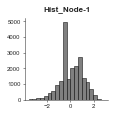

<Figure size 216x216 with 0 Axes>

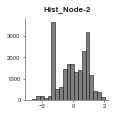

<Figure size 216x216 with 0 Axes>

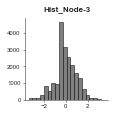

<Figure size 216x216 with 0 Axes>

In [15]:
from scivae import Vis

vis = Vis(vae, vae.u, None)
vis.plot_node_hists(show_plt=True, save_fig=False)

## Quality control 2: Visualise the correlation between features.

Since the VAE isn't magic, just good at learning correlations/patterns between input features, it's sensible 
to check that the correlations between features and nodes exists.

1 forebrain 10.5-days  H3K27ac 0.4458199156559925 0.0
1 forebrain 10.5-days  H3K27me3 -0.36822856875234455 0.0
1 forebrain 10.5-days  H3K36me3 0.7182105590240476 0.0
1 forebrain 10.5-days  H3K4me1 0.08458726186139696 1.0252935071364138e-33
1 forebrain 10.5-days  H3K4me3 0.44107422217939335 0.0
1 forebrain 10.5-days  H3K9me3 0.3322304714711835 0.0
1 forebrain 13.5-days  H3K36me3 0.7569123576516704 0.0
1 forebrain 16.5-days  H3K9ac 0.39801675553415206 0.0
1 hindbrain 10.5-days  H3K27ac 0.44252869028028696 0.0
1 hindbrain 10.5-days  H3K27me3 -0.3771528991191724 0.0
1 hindbrain 10.5-days  H3K36me3 0.7321705949738145 0.0
1 hindbrain 10.5-days  H3K4me1 0.06973185019912057 2.036931562717694e-23
1 hindbrain 10.5-days  H3K4me3 0.45126012014510813 0.0
1 hindbrain 10.5-days  H3K9me3 0.3264817001379393 0.0
1 hindbrain 16.5-days  H3K36me3 0.7714628829696493 0.0
1 midbrain 10.5-days  H3K27ac 0.4503315853763465 0.0
1 midbrain 10.5-days  H3K27me3 -0.3666337452858759 0.0
1 midbrain 10.5-days  H3K36me3 

<Figure size 216x216 with 0 Axes>

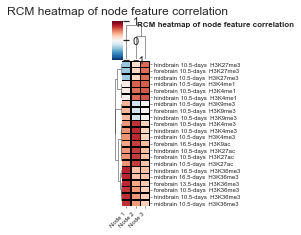

,Node 1,Node 1 padj,Node 2,Node 2 padj,Node 3,Node 3 padj,labels
0,0.445820,0.0,0.699384,0.0,0.289066,0.000,forebrain 10.5-days H3K27ac
1,-0.368229,0.0,0.206595,0.0,0.559386,0.000,forebrain 10.5-days H3K27me3
2,0.718211,0.0,0.436143,0.0,0.231238,0.000,forebrain 10.5-days H3K36me3
3,0.084587,0.0,0.556536,0.0,0.621673,0.000,forebrain 10.5-days H3K4me1
4,0.441074,0.0,0.723878,0.0,0.237898,0.000,forebrain 10.5-days H3K4me3
5,0.332230,0.0,-0.195348,0.0,0.025472,0.000,forebrain 10.5-days H3K9me3
6,0.756912,0.0,0.385921,0.0,0.263760,0.000,forebrain 13.5-days H3K36me3
7,0.398017,0.0,0.695181,0.0,0.316142,0.000,forebrain 16.5-days H3K9ac
8,0.442529,0.0,0.700506,0.0,0.304733,0.000,hindbrain 10.5-days H3K27ac
9,-0.377153,0.0,0.185570,0.0,0.562586,0.000,hindbrain 10.5-days H3K27me3


In [16]:
vis.plot_node_feature_correlation(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, save_fig=False)

## Having fun with inspecting the latent space

Now we are confident it's learnt stuff, let's look at how all our genes look on the latent space!

<Figure size 144x144 with 0 Axes>

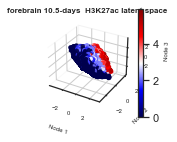

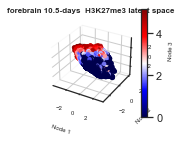

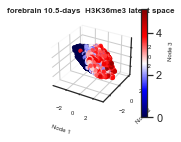

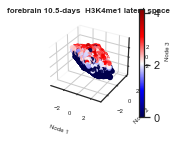

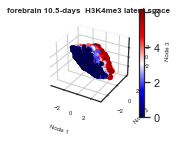

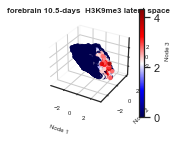

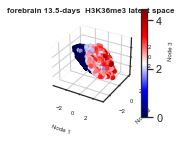

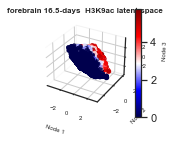

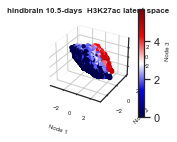

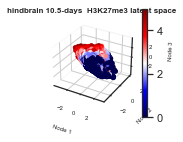

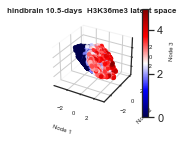

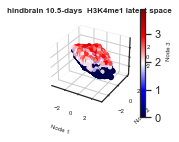

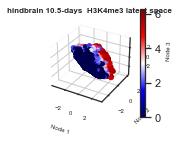

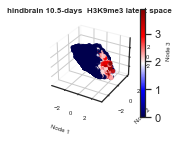

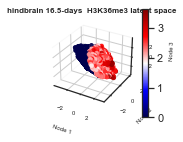

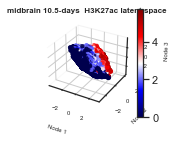

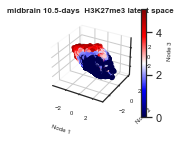

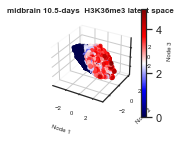

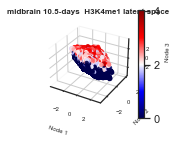

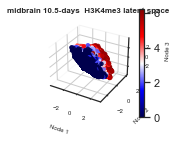

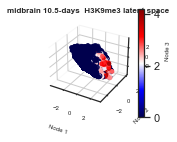

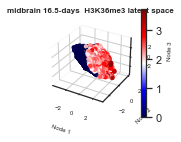

In [19]:
vis.plot_feature_scatters(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, fig_type="png", 
                          save_fig=False,
                          title="latent space")


## Plot specific genes

Since we love certain genes, lets have a look at where they are on the latent space

<Figure size 144x144 with 0 Axes>

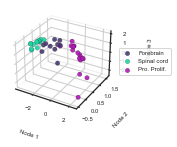

<Axes3DSubplot:xlabel='Node 1', ylabel='Node 2'>

In [17]:
cool_genes = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6', 'Arx', 'Dlx1', 'Dlx2', 'Dlx5', 'Nr2e2', 'Otx2'],
              ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11',
              'Hoxa13',
              'Hoxb9', 'Hoxb13', 'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
              ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a',
               'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a']
              ]

vis.plot_values_on_scatters(vae_df, "external_gene_name", ['Forebrain', 'Spinal cord', 'Pro. Prolif.'],
                            cool_genes, show_plt=True, fig_type=".png",
                            save_fig=False)
        